In [20]:
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys
from PIL import Image

## Load data

In [21]:
network_dim = int(256/2)  # ensure that this is always greater than max node number that occurs in your data
                      # in addition it needs to fit to the unet layer for concatenation

In [22]:
#masks = glob.glob("../input/graph_images/train/label/*.png")
masks = np.load('../input/graph_images/train/label/adjcouput_matrix.npy',allow_pickle='TRUE').item()
orgs = glob.glob("../input/graph_images/train/image/*.png")

In [23]:
imgs_list = []
masks_list = []
for image, mask in zip(orgs, masks):
    imgs_list.append(np.array(Image.open(image).convert('L').resize((512,512))))
    #print(image)
    key = image
    #print(key[-14:-9])
    graph_label = masks[key[-14:-9]]
    masks_list.append(np.array(graph_label))

imgs_np = np.asarray(imgs_list)
masks_np = np.asarray(masks_list)
y_positions_label = masks_np[:,:,0:2]
y_adjacency_label = masks_np[:,:,2:37]

# form position matrix and adjacency in a one dimensional vector information
y_positions_label = y_positions_label.reshape((y_positions_label.shape[0],y_positions_label.shape[1]*2))

adjacency_label_indices = np.triu_indices(y_adjacency_label.shape[1], k = 1)
y_adjacency_label =y_adjacency_label[:,adjacency_label_indices[0],adjacency_label_indices[1]]
y_label = [y_positions_label,y_adjacency_label]
print('total number of positions: ', y_positions_label.shape)
print('total number of relevant adjacency etries: ', y_adjacency_label.shape)

total number of positions:  (100, 70)
total number of relevant adjacency etries:  (100, 595)


In [24]:
print(imgs_np.shape, y_label[0].shape, y_label[1].shape )

(100, 512, 512) (100, 70) (100, 595)


## Plot images + masks + overlay (mask over original)

In [25]:
from keras_unet.utils import plot_imgs
#plot_imgs(org_imgs=imgs_np, mask_imgs=masks_np, nm_img_to_plot=10, figsize=6)

## Get data into correct shape, dtype and range (0.0-1.0)

In [26]:
print(imgs_np.max(), masks_np.max())

255 1.0


In [27]:
x = np.asarray(imgs_np, dtype=np.float32)/255
#y = np.asarray(masks_np, dtype=np.float32)/255

In [28]:
# tailor the data to the specific pre defined network dimension
y_label_positions = y_label[0]
y_label_adjacency = y_label[1]

a = np.full((y_label_positions.shape[0],network_dim *2), -9.9)
adj_flatten_dim = int((network_dim*network_dim-network_dim)/2)
b = np.zeros((y_label[1].shape[0],adj_flatten_dim))

a[:,0:y_label_positions.shape[1]] = y_label_positions
b[:,0:y_label_adjacency.shape[1]]= y_label_adjacency

y_label = [a, b]

In [29]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

##  Train/val split

In [30]:
from sklearn.model_selection import train_test_split
# split data
x_train, x_val, y_train_positions,y_val_positions, y_train_adjacency, y_val_adjacency = train_test_split(x, y_label[0], y_label[1], test_size=0.5, random_state=0)
print("x_train: ", x_train.shape)
print("y_train_positions: ", y_train_positions.shape)
print(" y_train_adjacency: ", y_train_adjacency.shape)
print("x_val: ", x_val.shape)
print("y_val_positions: ", y_val_positions.shape)
print("y_val_adjacency: ", y_val_adjacency.shape)

from models_graph.prepare_functions import convert_to_tensor

# convert from numpy to tensorflow object
x_train = convert_to_tensor(x_train)
x_val = convert_to_tensor(x_val)
y_train_positions = convert_to_tensor(y_train_positions)
y_train_adjacency = convert_to_tensor(y_train_adjacency)
y_val_positions = convert_to_tensor(y_val_positions)
y_val_adjacency = convert_to_tensor(y_val_adjacency)

x_train:  (50, 512, 512, 1)
y_train_positions:  (50, 256)
 y_train_adjacency:  (50, 8128)
x_val:  (50, 512, 512, 1)
y_val_positions:  (50, 256)
y_val_adjacency:  (50, 8128)


## Initialize network

In [31]:
from models_graph.custom_graph_head import custom_graph_head, custom_adj_unet
model = custom_adj_unet(input_size = input_shape, pretrained_weights =None, network_dim = network_dim)

## Network shape

In [32]:
print('Input Shape: ',model.input_shape)
print('Output Shape: ',model.output_shape)
print('with position vector: ',model.output_shape[0], ' and adjacency vector: ', model.output_shape[1])

model.summary()

Input Shape:  (None, 512, 512, 1)
Output Shape:  [(None, 256), (None, 8128)]
with position vector:  (None, 256)  and adjacency vector:  (None, 8128)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 512, 512, 64) 640         input_image[0][0]                
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_16[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 256

In [33]:
import os
os.environ["PATH"] += os.pathsep + "C:\\Program Files\\Graphviz\\bin\\"
import sys
print(sys.path)
sys.path.append("C:\\Program Files\\Graphviz\\bin\\")

['C:\\Users\\Schüle\\git\\LearnGraphExtraction\\keras-unet\\notebooks', 'C:\\Users\\Schüle\\git\\LearnGraphExtraction', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\Lib', 'c:\\users\\schüle\\appdata\\local\\programs\\python\\python37\\python37.zip', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\DLLs', 'c:\\users\\schüle\\appdata\\local\\programs\\python\\python37', '', 'C:\\Users\\Schüle\\AppData\\Roaming\\Python\\Python37\\site-packages', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\deepwalk-1.0.3-py3.7.egg', 'c:\\users\\schüle\\git\\labelme', 'c:\\users\\schüle\\git\\learngraphextraction\\keras-unet', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\win32', 'C:\\Users\\Schüle\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Schüle\\AppData\\Local\\Pro

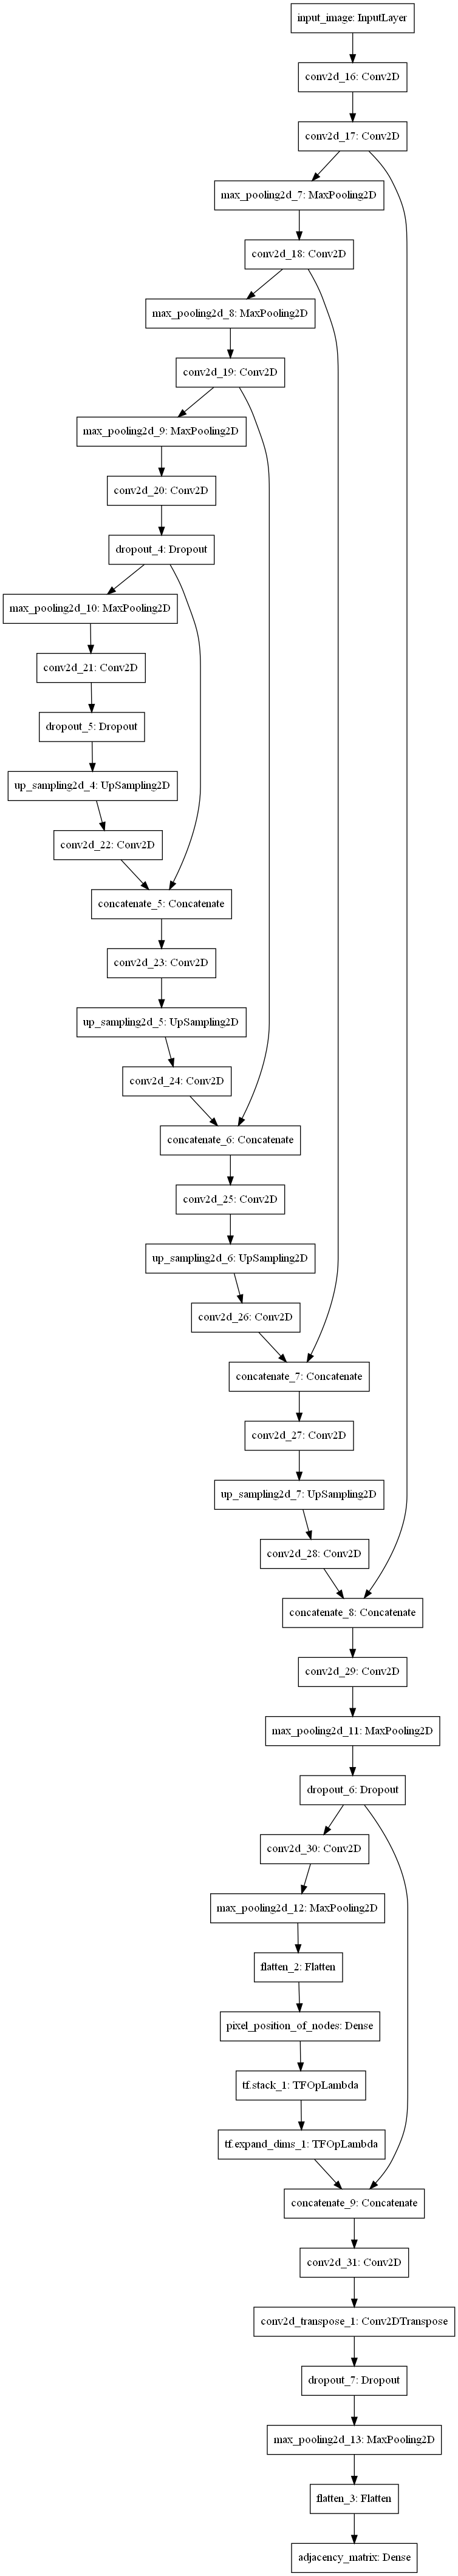

In [34]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

## Compile + train

In [35]:
import keras
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from models_graph.losses import loss_node_positions
from models_graph.losses import loss_adjacency
# model.compile(
#      optimizer=keras.optimizers.RMSprop(1e-3),
#      loss={
#          "pixel_position_of_nodes": loss_node_positions,
#          "adjacency_matrix":  loss_adjacency,
#      },
#      loss_weights=[1.0, 1.0],
#  )
model.compile(
   optimizer=keras.optimizers.RMSprop(1e-3),
   loss={
       "pixel_position_of_nodes": keras.losses.MeanSquaredError(),
       "adjacency_matrix":   keras.losses.BinaryCrossentropy(),
   },
   loss_weights=[0.8, 1.0],
)
print('done')
model.output

done


[<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'pixel_position_of_nodes')>,
 <KerasTensor: shape=(None, 8128) dtype=float32 (created by layer 'adjacency_matrix')>]

In [36]:
from models_graph.losses import loss_node_positions
from models_graph.losses import loss_adjacency

print(y_train_adjacency.shape)
print(y_train_positions.shape)
print(y_val_positions.shape)
print(y_val_adjacency.shape)
# model.fit({'input_image': x_train},{'pixel_position_of_nodes': y_train_positions, 'adjacency_matrix': y_train_adjacency},
#           epochs = 1, batch_size=2 ,
#           validation_data=({'input_image': x_val},{'pixel_position_of_nodes': y_val_positions, 'adjacency_matrix': y_val_adjacency}),
#         )
#
model.fit(x_train, [y_train_positions, y_train_adjacency],
          epochs = 10, batch_size=2 ,
          validation_data=(x_val,{'pixel_position_of_nodes': y_val_positions, 'adjacency_matrix': y_val_adjacency}),
           )
#model.fit(x= x_train,y=[y_train_positions, y_train_adjacency] , epochs=10)

(50, 8128)
(50, 256)
(50, 256)
(50, 8128)
Epoch 1/10
25/25 [==============================] - ETA: 0s - loss: 115063.7163 - pixel_position_of_nodes_loss: 143820.7729 - adjacency_matrix_loss: 7.0899  

KeyboardInterrupt: 

## Plot training history

In [ ]:
from keras_unet.utils import plot_segm_history
plot_segm_history(history)

## Plot original + ground truth + pred + overlay (pred on top of original)

In [ ]:
model.load_weights(model_filename)
y_pred = model.predict(x_val)

In [ ]:
from keras_unet.utils import plot_imgs
plot_imgs(org_imgs=x_val, mask_imgs=y_val, pred_imgs=y_pred, nm_img_to_plot=9)